In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [2]:
! chmod 600 /content/kaggle.json

In [4]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 97% 694M/714M [00:06<00:00, 148MB/s]
100% 714M/714M [00:06<00:00, 119MB/s]


In [5]:
import zipfile
zip_file = zipfile.ZipFile('/content/lgg-mri-segmentation.zip', 'r')
zip_file.extractall('/tmp/')


In [6]:
im_width = 256
im_height = 256

In [7]:
image_filenames_train = []

mask_files = glob('/tmp/kaggle_3m/*/*_mask.tif')

for i in mask_files:
  image_filenames_train.append(i.replace('_mask', '') )

print(image_filenames_train[:10], sep='\n') 

['/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_2.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_8.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_36.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_10.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_21.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_26.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_11.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_31.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_3.tif', '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_32.tif']


In [8]:
image_filenames_train[:10]

['/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_2.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_8.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_36.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_10.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_21.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_26.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_11.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_31.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_3.tif',
 '/tmp/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_32.tif']

In [8]:
len(image_filenames_train)

3929

#Plot


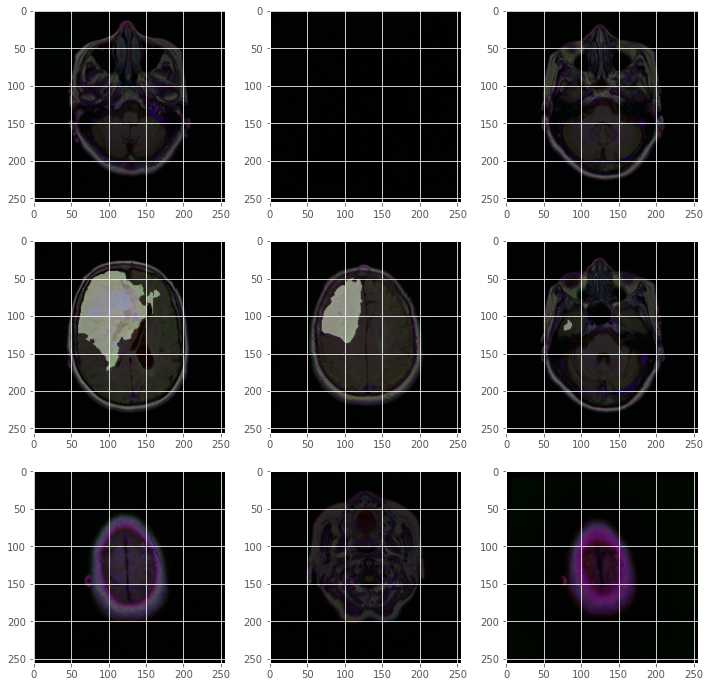

In [9]:
plot_from_img_path(3, 3, image_filenames_train, mask_files)

In [9]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask':mask_files})

df_train, df_test = train_test_split(df, test_size=0.1)

df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)



(2828, 2)
(393, 2)
(708, 2)


#Adjust data and data generator

In [10]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [11]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [12]:
EPOCHS = 30
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [13]:
model = unet()
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f2dc0512c70>>

In [15]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/30
89/88 [==============================] - ETA: -1s - loss: -0.1306 - binary_accuracy: 0.9068 - iou: 0.0719 - dice_coefficients: 0.1310Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01967, saving model to unet.hdf5
88/88 [==============================] - 198s 2s/step - loss: -0.1306 - binary_accuracy: 0.9068 - iou: 0.0719 - dice_coefficients: 0.1310 - val_loss: -0.0197 - val_binary_accuracy: 0.9904 - val_iou: 0.0100 - val_dice_coefficients: 0.0196
Epoch 2/30
89/88 [==============================] - ETA: 0s - loss: -0.2328 - binary_accuracy: 0.9878 - iou: 0.1348 - dice_coefficients: 0.2341
Epoch 2: val_loss improved from -0.01967 to -0.07709, saving model to unet.hdf5
88/88 [==============================] - 145s 2s/step - loss: -0.2328 - binary_accuracy: 0.9878 - iou: 0.1348 - dice_coefficients: 0.2341 - val_loss: -0.0771 - val_bina

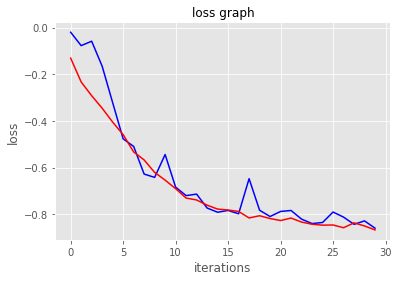

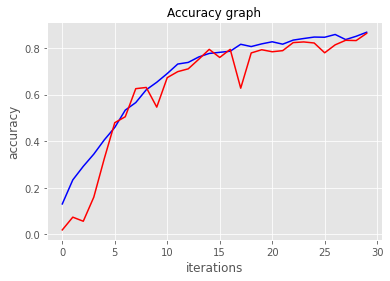

In [16]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

In [17]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients} )

In [18]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 12s 971ms/step - loss: -0.8675 - binary_accuracy: 0.9977 - iou: 0.7683 - dice_coefficients: 0.8681
Test Loss  -0.8675193190574646
Test IoU  0.9977129697799683
Test Dice Coefficient  0.7682664394378662


1/1 [==============================] - 2s 2s/step


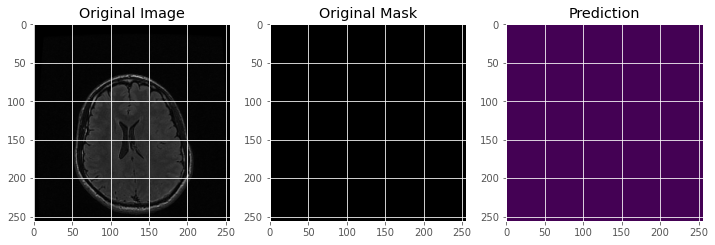

1/1 [==============================] - 0s 17ms/step


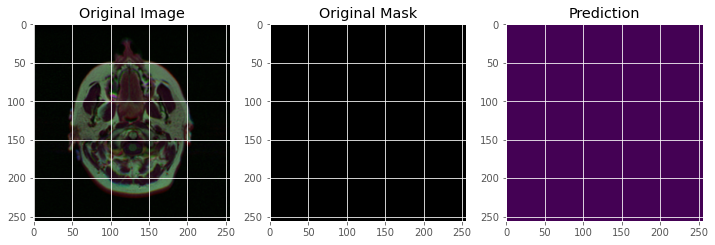

1/1 [==============================] - 0s 17ms/step


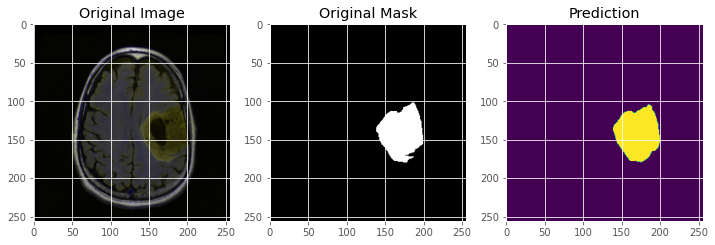

1/1 [==============================] - 0s 17ms/step


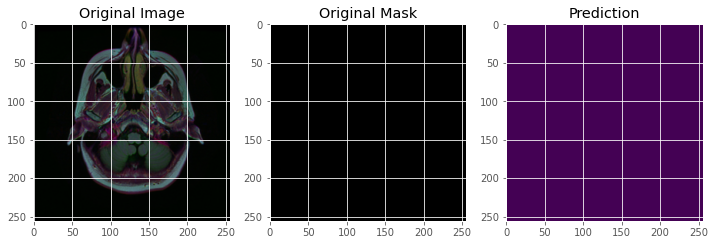

1/1 [==============================] - 0s 19ms/step


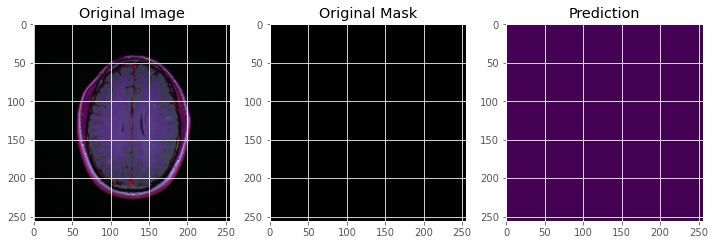

1/1 [==============================] - 0s 25ms/step


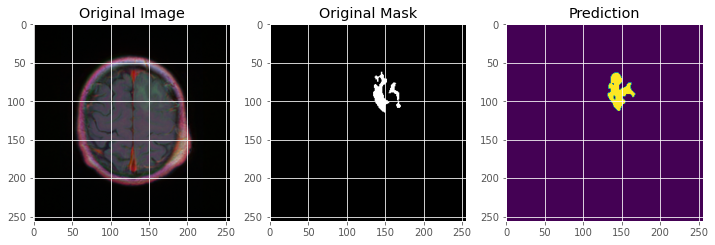

1/1 [==============================] - 0s 17ms/step


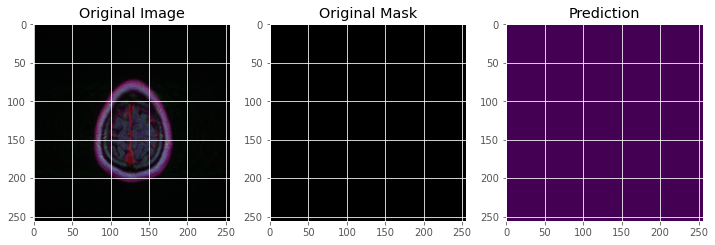

1/1 [==============================] - 0s 17ms/step


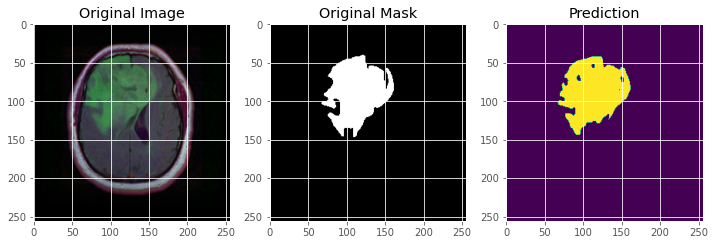

1/1 [==============================] - 0s 18ms/step


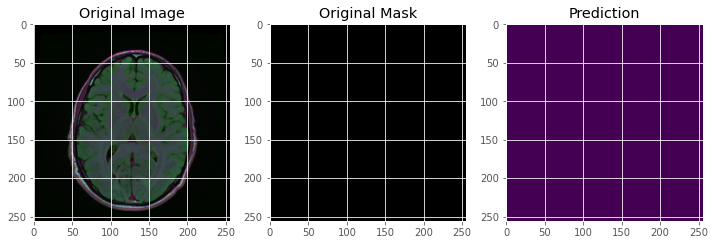

1/1 [==============================] - 0s 19ms/step


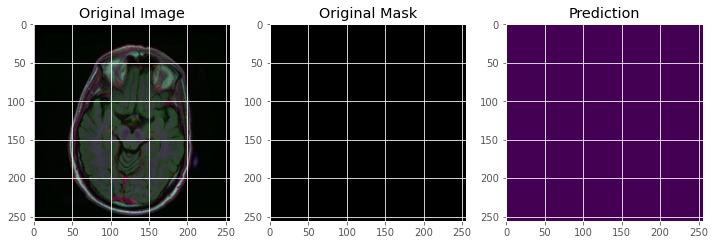

1/1 [==============================] - 0s 18ms/step


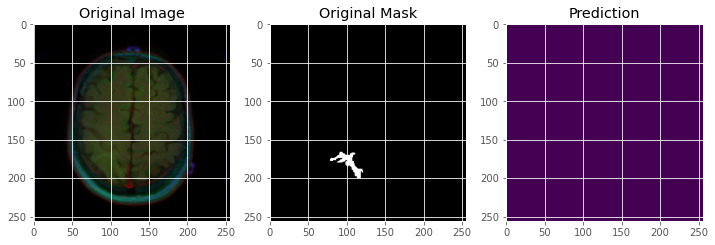

1/1 [==============================] - 0s 19ms/step


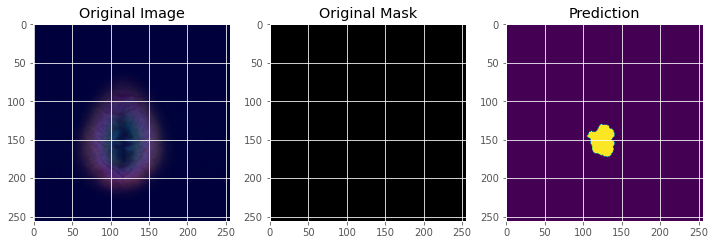

1/1 [==============================] - 0s 18ms/step


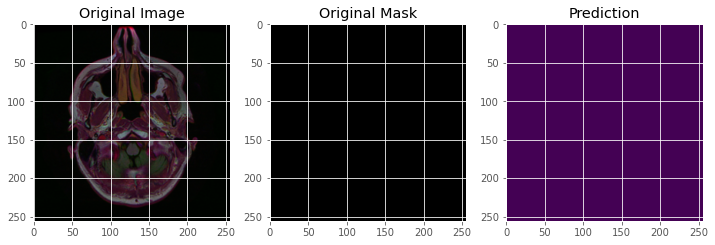

1/1 [==============================] - 0s 20ms/step


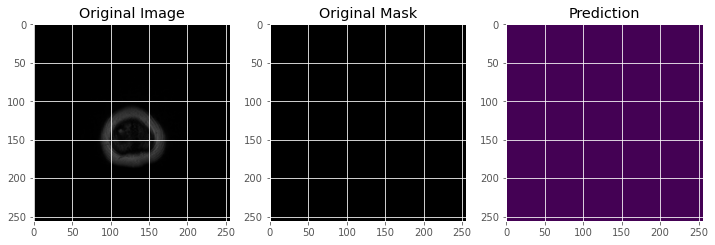

1/1 [==============================] - 0s 21ms/step


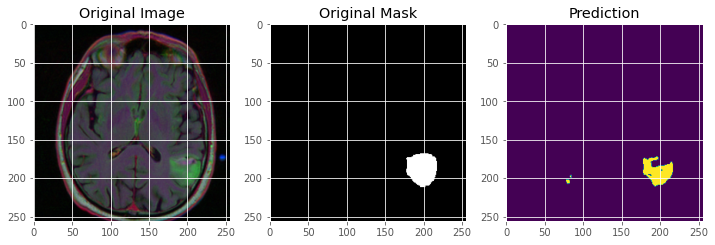

1/1 [==============================] - 0s 17ms/step


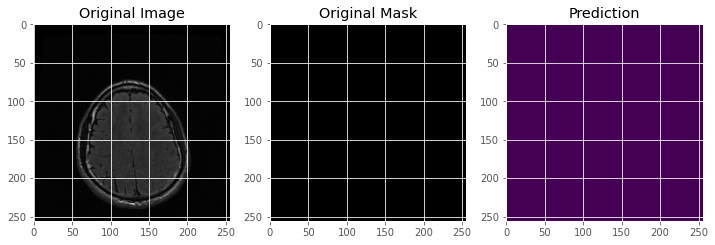

1/1 [==============================] - 0s 18ms/step


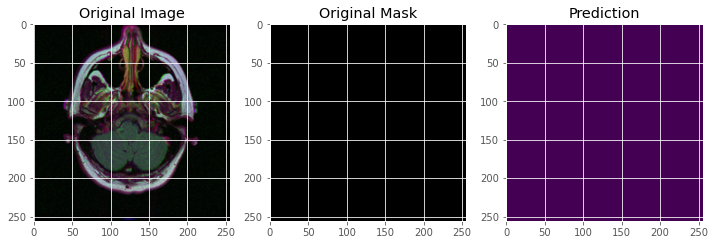

1/1 [==============================] - 0s 17ms/step


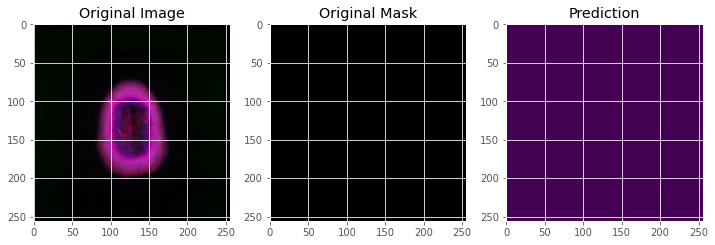

1/1 [==============================] - 0s 17ms/step


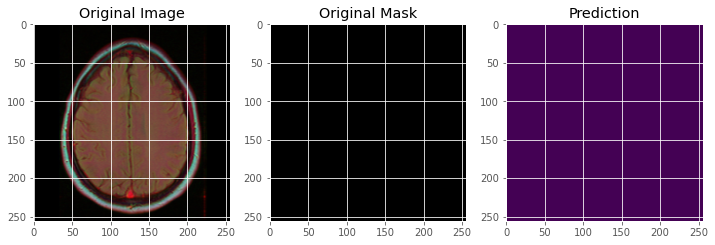

1/1 [==============================] - 0s 18ms/step


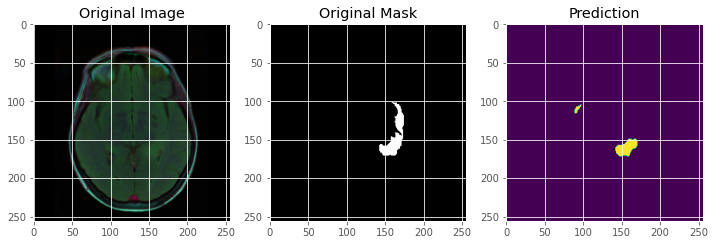

In [19]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

#Experiment


menggunakan model yang telah dilatih dengan epoch 100

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
model = load_model('unet-100.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients} )

In [17]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 34s 916ms/step - loss: -0.9001 - binary_accuracy: 0.9981 - iou: 0.8267 - dice_coefficients: 0.9037
Test Loss  -0.9000533819198608
Test IoU  0.9981096386909485
Test Dice Coefficient  0.8266986012458801
